# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
''' Define your transforms (to normalize the data) for the training and validation sets '''
# Most of the pretrained models require the input to be 224x224 images. 
# Also, we'll need to match the normalization used when the models were trained.
# Each color channel was normalized separately, the means are [0.485, 0.456, 0.406].
# And the standard deviations are [0.229, 0.224, 0.225].
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch
# And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network

# Use GPU if it's available
# If you try to train this on a CPU like normal, it will take a long, long time. 
# Instead, we're going to use the GPU to do the calculations.
# The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds.
# It's also possible to train on multiple GPUs, further decreasing training time.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pre-trained network
model = models.vgg19(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
''' Create the network, define the criterion and optimizer '''
# Create a network with 25088 input units, a hidden layer with Y units and a ReLU activation.
# Then a hidden layer with X units and a ReLU activation,
# And finally an output layer with a softmax activation

# This model is built out of two main parts, the features and the classifier.
# The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier.
# The classifier part is a single fully-connected layer (classifier): Linear(in_features=X, out_features=102).

# nn.Linear(25088, X): Inputs to hidden layer linear transformation
# This line creates a module for a linear transformation,  xW+b , with 25088 inputs and X outputs and assigns it to self.hidden.
# The module automatically creates the weight and bias tensors which we'll use in the forward method.

# nn.Linear(X, 102): Output layer, 102 units - one for each flower specie
# Similarly, this creates another linear transformation with X inputs and 102 outputs.

# The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. 
# This forces the network to share information between weights, increasing it's ability to generalize to new data.
# Adding dropout in PyTorch is straightforward using the nn.Dropout module.
# Dropout module with 0.2 drop probability

# To calculate the probability distribution, we often use the softmax function.
model.classifier = nn.Sequential(nn.Linear(25088, 2048),
                                 nn.ReLU(),
                                 nn.Linear(2048, 102),
                                 nn.Dropout(0.2),                                 
                                 nn.LogSoftmax(dim=1))

# At first the network is naive, it doesn't know the function mapping the inputs to the outputs. 
# We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.
# To find these parameters, we need to know how poorly the network is predicting the real outputs. 
# For this we calculate a loss function (also called the cost), a measure of our prediction error.
# By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy.
# We find this minimum using a process called gradient descent.
# The gradient is the slope of the loss function and points in the direction of fastest change.
# To get to the minimum in the least amount of time, we then want to follow the gradient (downwards).
# You can think of this like descending a mountain by following the steepest slope to the base.
# We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.
# To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network.
# We update our weights using this gradient with some learning rate α.
# The learning rate α is set such that the weight update steps are small enough that the iterative method settles in a minimum.

# Define the criterion (something like nn.CrossEntropyLoss or nn.NLLLoss) and the optimizer (typically optim.SGD or optim.Adam).
# To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.
criterion = nn.NLLLoss()

# Optimizers require the parameters to optimize and a learning rate
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0003)

# PyTorch, along with pretty much every other deep learning framework, uses CUDA to efficiently compute the forward and backwards passes on the GPU. 
# In PyTorch, you move your model parameters and other tensors to the GPU memory using model.to('cuda').
# You can move them back from the GPU with model.to('cpu') which you'll commonly do when you need to operate on the network output outside of PyTorch.
model.to(device);

cuda


In [6]:
# one pass through the entire dataset is called an epoch. 
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    # The training pass is a fairly straightforward process:
    # - Make a forward pass through the network to get the logits
    # - Use the logits to calculate the loss
    # - Perform a backward pass through the network with loss.backward() to calculate the gradients
    # - Take a step with the optimizer to update the weights
    
    # So here we're going to loop through trainloader to get our training batches.
    # For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # When you do multiple backwards passes with the same parameters, the gradients are accumulated.
        # This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.
        optimizer.zero_grad()
        
        # Forward pass, get our logits
        logps = model.forward(inputs)
        # Calculate the loss with the logits and the labels
        loss = criterion(logps, labels)
        # Perform a backward pass through the network with loss.backward() to calculate the gradients
        loss.backward()
        # Take an update step and few the new weights
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            # During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. 
            # So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use model.eval(). 
            # This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with model.train().
            # In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.
            model.eval()
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                # validation pass here
                for inputs, labels in testloader:
                    # Move input and label tensors to the default device
                    inputs, labels = inputs.to(device), labels.to(device)
                    # Forward pass, get our logits
                    logps = model.forward(inputs)
                    # Calculate the loss with the logits and the labels
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ''' Calculate accuracy '''
                    # Get the class probabilities
                    ps = torch.exp(logps) 
                    # With the probabilities, we can get the most likely class using the ps.topk method. This returns the k highest values. 
                    # Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-k values and the top-k indices.
                    # If the highest value is the fifth element, we'll get back 4 as the index.
                    top_p, top_class = ps.topk(1, dim=1)
                    # Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes.
                    # Here top_class is a 2D tensor with shape (X, 1) while labels is 1D with shape (X).
                    # To get the equality to work out the way we want, top_class and labels must have the same shape.
                    # If we do "equals = top_class == labels", equals will have shape (X, X). 
                    # What it's doing is comparing the one element in each row of top_class with each element in labels which returns X True/False boolean values for each row.
                    equals = top_class == labels.view(*top_class.shape)
                    # Now we need to calculate the percentage of correct predictions.
                    # equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. 
                    # This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean.
                    # torch.mean isn't implement for tensors with that type. So we'll need to convert equals to a float tensor.
                    # Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            # Check if our model is not overfitting, i.e., the training and validation metrics are not diverging too much.
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            # set model back to train mode
            model.train()

Epoch 1/10.. Train loss: 4.451.. Test loss: 3.630.. Test accuracy: 0.295
Epoch 1/10.. Train loss: 3.562.. Test loss: 2.508.. Test accuracy: 0.477
Epoch 1/10.. Train loss: 2.921.. Test loss: 1.885.. Test accuracy: 0.582
Epoch 1/10.. Train loss: 2.446.. Test loss: 1.498.. Test accuracy: 0.675
Epoch 1/10.. Train loss: 2.407.. Test loss: 1.145.. Test accuracy: 0.755
Epoch 2/10.. Train loss: 2.068.. Test loss: 1.056.. Test accuracy: 0.762
Epoch 2/10.. Train loss: 1.840.. Test loss: 0.918.. Test accuracy: 0.782
Epoch 2/10.. Train loss: 1.813.. Test loss: 0.894.. Test accuracy: 0.793
Epoch 2/10.. Train loss: 1.758.. Test loss: 0.819.. Test accuracy: 0.810
Epoch 2/10.. Train loss: 1.663.. Test loss: 0.719.. Test accuracy: 0.821
Epoch 3/10.. Train loss: 1.688.. Test loss: 0.764.. Test accuracy: 0.816
Epoch 3/10.. Train loss: 1.610.. Test loss: 0.665.. Test accuracy: 0.833
Epoch 3/10.. Train loss: 1.513.. Test loss: 0.654.. Test accuracy: 0.836
Epoch 3/10.. Train loss: 1.508.. Test loss: 0.645..

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [7]:
# TODO: Save the checkpoint 
# It's impractical to train a network every time you need to use it.
# Instead, we can save trained networks then load them later to train more or use them for predictions.
# The simplest thing to do is simply save the state dict with torch.save. 
# For example, we can save it to a file 'checkpoint.pth'.
# Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture.
# If I create a model with a different architecture, this fails.
# This means we need to rebuild the model exactly as it was when trained.
# Information about the model architecture needs to be saved in the checkpoint, along with the state dict.
# To do this, you build a dictionary with all the information you need to compeletely rebuild the model.
checkpoint = {'arch': 'vgg19',
              'input_size': 25088,
              'hidden_size': 2048,
              'output_size': 102,              
              'state_dict': model.state_dict(),
              'class_to_idx': test_data.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [8]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint):
    checkpoint = torch.load('checkpoint.pth')

    # Load pre-trained network
    if (checkpoint['arch'] == 'vgg19'):
        model = models.vgg19(pretrained=True)
    else:
        return none

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    # Create the classifier
    model.classifier = nn.Sequential(nn.Linear(checkpoint['input_size'], checkpoint['hidden_size']),
                                     nn.ReLU(),
                                     nn.Linear(checkpoint['hidden_size'], checkpoint['output_size']),
                                     nn.Dropout(0.2),                                 
                                     nn.LogSoftmax(dim=1))

    # The parameters for PyTorch networks are stored in a model's state_dict.
    # The state dict contains the weight and bias matrices for each of our layers.
    model.load_state_dict(checkpoint['state_dict'])
    
    # mapping of classes to indices
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [9]:
model = load_model('checkpoint.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_transforms = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    
    pil_image = Image.open(image)
    pil_image = pil_transforms(pil_image).float()
    
    return pil_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

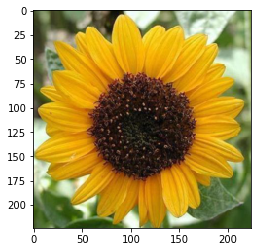

In [12]:
# preprocessed image
image_path = valid_dir + '/54/image_05415.jpg'
img = process_image(image_path)
imshow(img)

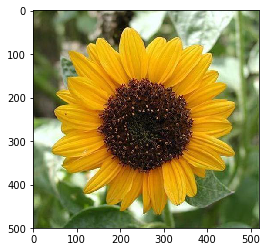

In [13]:
# Original image
original = mpimg.imread(image_path)
imgplot = plt.imshow(original)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    img = process_image(image_path)
    
    with torch.no_grad():
        # Convert 2D image to 1D vector
        img = np.expand_dims(img, 0)
    
        img = torch.from_numpy(img)
    
        inputs = img.to(device)
        logps = model.forward(inputs)
        
        ps = torch.exp(logps)        
        probs, indices = torch.topk(ps, topk)
        probs = [float(prob) for prob in probs[0]]
        inv_map = {v: k for k, v in model.class_to_idx.items()}
        classes = [inv_map[int(index)] for index in indices[0]]
    
    return probs, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

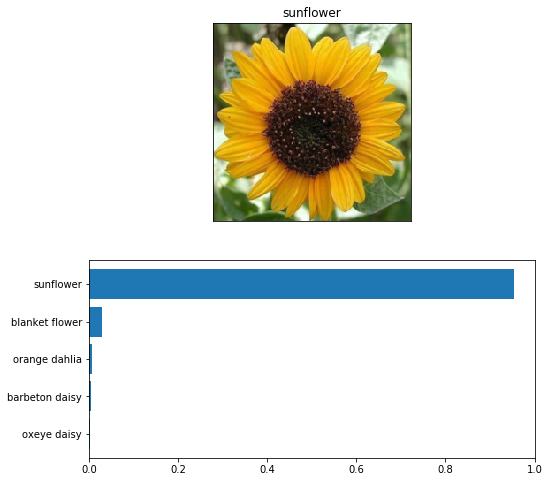

In [15]:
# TODO: Display an image along with the top 5 classes
f = plt.figure(figsize=(8,8))

ax = f.add_subplot(211)
img = process_image(image_path)
imshow(img, ax=ax)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('sunflower')

plt.subplot(212)
probs, classes = predict(image_path, model, topk=5)
classes_name = [cat_to_name[class_i] for class_i in classes]
plt.barh(range(len((classes_name))), probs)
plt.yticks(range(len(classes_name)),classes_name)
plt.gca().invert_yaxis()